In [1]:
import numpy as np
import itertools
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
from scipy.stats import linregress

from bamf.bamfCR import *

import time

# set plot parameters
params = {'legend.fontsize': 18,
          'figure.figsize': (8, 7),
          'axes.labelsize': 24,
          'axes.titlesize':24,
          'axes.linewidth':3,
          'xtick.labelsize':20,
          'ytick.labelsize':20,
          'xtick.labelsize':20,
          'ytick.labelsize':20}
plt.rcParams.update(params)
plt.style.use('seaborn-colorblind')
plt.rcParams['pdf.fonttype'] = 42

np.random.seed(123)



<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Import data

In [2]:
# used later for model validation
gLV_data = pd.read_csv("gLV_data/MS008_processed_mono.csv")
gLV_data.head()

,Treatments,Time,CA,BT,BU,CS,CD,DP,CH,BV
0,MS008-BT,0.0,0.0,0.00500,0.000000,0.0,0.005000,0.0,0.0,0.0
1,MS008-BT,12.0,0.0,1.08115,0.000000,0.0,0.337850,0.0,0.0,0.0
2,MS008-BT,24.0,0.0,0.96386,0.000000,0.0,0.202807,0.0,0.0,0.0
3,MS008-BU,0.0,0.0,0.00000,0.005000,0.0,0.005000,0.0,0.0,0.0
4,MS008-BU,12.0,0.0,0.00000,0.455992,0.0,0.565842,0.0,0.0,0.0


In [3]:
species = ['BU', 'BT', 'CS', 'CA']
BT_data = gLV_data.iloc[np.in1d(gLV_data.Treatments.values, [f"Monoculture{sp}" for sp in species])]
BT_data = BT_data[["Treatments", "Time"] + species]
BT_data

,Treatments,Time,BU,BT,CS,CA
177,MonocultureBT,0.0,0.0,0.022933,0.000000,0.0
178,MonocultureBT,3.0,0.0,0.172033,0.000000,0.0
179,MonocultureBT,6.0,0.0,0.470100,0.000000,0.0
180,MonocultureBT,9.0,0.0,0.811533,0.000000,0.0
181,MonocultureBT,12.0,0.0,0.703900,0.000000,0.0
...,...,...,...,...,...,...
310,MonocultureCS,54.0,0.0,0.000000,0.630833,0.0
311,MonocultureCS,57.0,0.0,0.000000,0.628900,0.0
312,MonocultureCS,60.0,0.0,0.000000,0.618500,0.0
313,MonocultureCS,63.0,0.0,0.000000,0.610633,0.0


# Define function to make predictions on test data

In [17]:
# Define function to make predictions on test data

def plot(model, df_test):
    all_treatments = df_test.Treatments.values
    unique_treatments = np.unique(all_treatments)
    numspecies = len(species)

    # pull a random community trajectory
    for treatment in unique_treatments:
        comm_inds = np.in1d(df_test['Treatments'].values, treatment)
        comm_data = df_test.iloc[comm_inds].copy()

        # make sure comm_data is sorted in chronological order
        comm_data.sort_values(by='Time', ascending=True, inplace=True)
        tspan = comm_data.Time.values

        # pull just the community data
        output_true = comm_data[species].values

        # run model using parameters
        x_test = np.copy(output_true[0, :])

        # increase teval
        t_eval = np.linspace(0, tspan[-1], 100)
        steps = len(t_eval)
        output, stdv, COV = model.predict_latent(x_test, t_eval)
        # output = model.predict_point(x_test, t_eval)

        # plot the results
        plt.figure(figsize=(9, 6))
        ylim = 0
        for i, sp in enumerate(species):
            out = output[:,i]
            out_true = output_true[:, i]
            if out[0] > 0:
                plt.scatter(tspan, out_true, color='C{}'.format(i))
                plt.plot(t_eval, out, label=f"Predicted {sp}", color='C{}'.format(i))
                plt.fill_between(t_eval, out-stdv[:, i], out+stdv[:, i], color='C{}'.format(i), alpha=0.2)
                
        plt.xlabel("Time (hr)")
        plt.ylabel("Species abundance")
        #plt.legend(loc='upper left')
        plt.title(f"C-R+NN fit to monoculture")
        plt.savefig("figures/CRNN_mono_s.pdf")
        plt.show()
        
        # plot predictions of hidden variables
        for k in range(output.shape[-1] - (i+1)):
            plt.plot(t_eval, np.exp(output[:,i+1+k]), label=f"Predicted R{k+1}", color=f'C{k+1}')
            '''plt.fill_between(t_eval, 
                             np.exp(output[:,i+1+k] - stdv[:,i+1+k]), 
                             np.exp(output[:,i+1+k] + stdv[:,i+1+k]), 
                             color=f'C{k+1}', alpha=0.2)'''

        plt.legend()
        plt.ylabel("Resource concentration")
        plt.xlabel("Time (hr)")
        plt.savefig("figures/CRNN_mono_r.pdf")
        plt.show()

# Initialize model parameters

In [5]:
# global parameters 
n_s = len(species)
n_r = 2
# input includes species, resources and time 
n_x = n_s + n_r 

# dimension of hidden layer
n_h = 10

# normalizing constant for time as input
t_max = np.max(gLV_data.Time.values)

# log of death rate 
d = -3*np.ones(n_s)

# map to hidden dimension
p_std = 1./np.sqrt(n_x)
W1 = p_std*np.random.randn(n_h, n_x)
b1 = np.random.randn(n_h)

# maximum consumption rate parameters
C = np.zeros([n_r, n_s]) 
C[0,0] = -1
C[0,1] = -1
# set prior s.t. monophasic growth curves are assumed to have one primary resource
C[0,2] = -10
C[0,3] = -10

# parameters to compute efficiency matrix
p_std = 1./np.sqrt(n_h)
W2 = p_std*np.random.randn(n_r, n_s, n_h) 

# log of efficiency of species
f = np.zeros(n_s)

# concatenate parameter initial guess
params = np.concatenate((d, W1.flatten(), b1, C.flatten(), W2.flatten()))#, f.flatten()))

# set prior so that C is sparse 
W1prior = np.zeros_like(W1)
b1prior = np.zeros_like(b1)
Cprior = -10*np.ones([n_r, n_s]) 
W2prior = np.zeros_like(W2)

# concatenate prior 
prior = np.concatenate((d, W1prior.flatten(), b1prior, Cprior.flatten(), W2prior.flatten()))#, f))

n_params = len(params)
n_params

162

# Define model

In [6]:
# using consumer resource model  
def system(t, x, params): 
    
    # species 
    s = x[:n_s]
    
    # resources
    r = jnp.exp(x[n_s:])
    
    # compute state (do not include time as an input!)
    state = jnp.concatenate((s, r)) 
    
    # death rate
    d = params[:n_s]
    
    # map to hidden layer
    W1 = np.reshape(params[n_s:n_s+n_x*n_h], [n_h, n_x])
    b1 = params[n_s+n_x*n_h:n_s+n_x*n_h+n_h]
    h  = jax.nn.tanh(W1@state + b1)
    
    # maximum consumption rate parameters
    Cmax = jnp.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
    
    # attractiveness of resource i to species j  
    W2 = np.reshape(params[n_s+n_x*n_h+n_h+n_r*n_s:n_s+n_x*n_h+n_h+n_r*n_s+n_r*n_s*n_h], [n_r, n_s, n_h])
    F  = jax.nn.sigmoid(jnp.einsum("ijk,k->ij", W2, h))
    
    # compute current resource consumption rate 
    C = jnp.einsum('ij,ij->ij', F, Cmax)
    
    # efficiency of species 
    # f = jnp.exp(params[n_s+n_x*n_h+n_h+n_r*n_s+n_r*n_s*n_h:])
    
    # rate of change of species 
    dsdt = s*(C.T@r - jnp.exp(d)) 

    # rate of change of log of resources 
    dlrdt = -C@s 

    return jnp.append(dsdt, dlrdt)

# Define observation matrix

In [7]:
# define observation matrices 
O = np.zeros([n_s, n_s+n_r])
O[:n_s,:n_s] = np.eye(n_s)
O

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]])

# Fit model to mono culture data

In [8]:
r0 = np.random.uniform(-3, 0, n_r)
#r0 = -np.ones(n_r)
print(r0)

model = ODE(system = system, 
            dataframe=BT_data,
            C=O,
            CRparams = params, 
            r0 = r0,
            prior = prior,
            species = species,
            alpha_0=1e-3,
            verbose=True)

# fit to data 
t0 = time.time()
model.fit(evidence_tol=1e-3, nlp_tol=1e-3)
print("Elapsed time {:.2f}s".format(time.time()-t0))

[-0.42183277 -0.53548766]
Updating precision...
Total samples: 352, Updated regularization: 1.00e-03
Total weighted fitting error: 5.284
Total weighted fitting error: 3.634
Total weighted fitting error: 2.961
Total weighted fitting error: 2.137
Total weighted fitting error: 1.051
Total weighted fitting error: 0.809
Total weighted fitting error: 0.717
Total weighted fitting error: 0.664
Total weighted fitting error: 0.593
Total weighted fitting error: 0.578
Total weighted fitting error: 0.553
Total weighted fitting error: 0.533
Total weighted fitting error: 0.506
Total weighted fitting error: 0.502
Total weighted fitting error: 0.501
Total weighted fitting error: 0.490
Total weighted fitting error: 0.489
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.4888484339104663
       x: [-3.270e-01 -2.229e-01 ... -2.161e-01  2.010e-01]
     nit: 17
     jac: [-6.624e-03 -1.061e-01 ...  1.075e-02 -9.946e-03]
    nfev: 19
    njev: 19
    nhev: 17
Evidence -3

Total weighted fitting error: 162.033
Total weighted fitting error: 161.661
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 161.66136500022358
       x: [-4.270e-01 -8.993e-02 ... -2.194e-01  2.825e-01]
     nit: 2
     jac: [-1.294e+01 -7.369e+01 ...  1.086e+01 -9.544e+00]
    nfev: 3
    njev: 3
    nhev: 2
Evidence 1091.413
Fail count  2
Updating precision...
Total samples: 352, Updated regularization: 3.65e-06
Total weighted fitting error: 159.336
Total weighted fitting error: 159.225
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 159.2249572741415
       x: [-4.949e-01 -8.900e-02 ... -2.435e-01  3.084e-01]
     nit: 2
     jac: [-8.138e+00 -1.447e+02 ... -1.101e+01  9.144e+00]
    nfev: 10
    njev: 10
    nhev: 2
Evidence 1098.954
Updating precision...
Total samples: 352, Updated regularization: 3.68e-06
Total weighted fitting error: 162.232
 message: Optimization terminated successfully.
 success: True
  

Total weighted fitting error: 164.273
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.2728417278914
       x: [-2.856e-01 -8.216e-02 ... -4.700e-01  5.477e-01]
     nit: 1
     jac: [-5.961e+01  9.586e+01 ...  1.785e+00 -1.591e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1199.041
Updating precision...
Total samples: 352, Updated regularization: 1.59e-06
Total weighted fitting error: 162.905
Total weighted fitting error: 162.803
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 162.80295586639016
       x: [-2.632e-01 -8.072e-02 ... -4.702e-01  5.485e-01]
     nit: 2
     jac: [-5.475e+00 -1.701e+02 ... -3.194e+00  2.737e+00]
    nfev: 4
    njev: 4
    nhev: 2
Evidence 1200.627
Updating precision...
Total samples: 352, Updated regularization: 1.57e-06
Total weighted fitting error: 164.945
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.9454092595036
       x: [-2.64

Total weighted fitting error: 166.366
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.36636236437676
       x: [-4.809e-02 -8.001e-02 ... -4.900e-01  5.849e-01]
     nit: 1
     jac: [-2.609e+01  1.714e+01 ...  1.135e+01 -9.736e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1235.290
Updating precision...
Total samples: 352, Updated regularization: 1.23e-06
Total weighted fitting error: 166.605
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.6052073263064
       x: [-4.420e-02 -8.013e-02 ... -4.895e-01  5.845e-01]
     nit: 1
     jac: [-1.393e+01 -9.903e+00 ... -1.490e+00  1.237e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1235.337
Updating precision...
Total samples: 352, Updated regularization: 1.23e-06
Total weighted fitting error: 164.256
Total weighted fitting error: 164.091
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 164.0908426494663
       x: [-1.58

Total weighted fitting error: 167.266
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.26616984089233
       x: [ 1.785e-01 -7.804e-02 ... -4.869e-01  5.937e-01]
     nit: 1
     jac: [-1.391e+00  3.489e+01 ... -3.502e+00  2.910e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1254.635
Updating precision...
Total samples: 352, Updated regularization: 1.02e-06
Total weighted fitting error: 165.913
Total weighted fitting error: 165.805
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 165.80498885486406
       x: [ 2.012e-01 -7.784e-02 ... -4.867e-01  5.946e-01]
     nit: 2
     jac: [ 4.527e+02 -4.627e+02 ... -6.867e+00  5.690e+00]
    nfev: 12
    njev: 12
    nhev: 2
Evidence 1256.143
Updating precision...
Total samples: 352, Updated regularization: 1.00e-06
Total weighted fitting error: 167.222
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.22238089556444
       x: [ 

Total weighted fitting error: 167.179
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.17927311925928
       x: [ 3.413e-01 -7.706e-02 ... -4.788e-01  5.962e-01]
     nit: 1
     jac: [-9.270e+00  1.138e+01 ...  1.277e+00 -1.029e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1266.799
Fail count  1
Updating precision...
Total samples: 352, Updated regularization: 9.08e-07
Total weighted fitting error: 166.458
Total weighted fitting error: 166.446
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.44633385313315
       x: [ 3.322e-01 -7.711e-02 ... -4.779e-01  5.959e-01]
     nit: 2
     jac: [-2.617e+02  1.969e+02 ...  7.532e-01 -6.154e-01]
    nfev: 7
    njev: 7
    nhev: 2
Evidence 1267.482
Updating precision...
Total samples: 352, Updated regularization: 9.03e-07
Total weighted fitting error: 166.877
Total weighted fitting error: 166.871
 message: Optimization terminated successfully.
 success: True
  s

Total weighted fitting error: 166.422
Total weighted fitting error: 166.410
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.41035648020278
       x: [ 3.209e-01 -7.707e-02 ... -4.544e-01  5.822e-01]
     nit: 2
     jac: [-3.094e+02  1.882e+02 ... -4.840e-01  3.763e-01]
    nfev: 5
    njev: 5
    nhev: 2
Evidence 1275.939
Updating precision...
Total samples: 352, Updated regularization: 8.44e-07
Total weighted fitting error: 167.691
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 167.69052462042302
       x: [ 3.209e-01 -7.705e-02 ... -4.544e-01  5.822e-01]
     nit: 1
     jac: [ 2.012e+01 -2.058e+01 ... -3.089e+00  2.479e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1275.965
Updating precision...
Total samples: 352, Updated regularization: 8.49e-07
Total weighted fitting error: 166.143
Total weighted fitting error: 166.050
 message: Optimization terminated successfully.
 success: True
  status: 0
     

Total weighted fitting error: 166.675
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.67475463916708
       x: [ 2.544e-01 -7.687e-02 ... -4.161e-01  5.510e-01]
     nit: 1
     jac: [-4.659e+01  1.714e+01 ...  3.376e-01 -2.863e-01]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1284.056
Fail count  2
Updating precision...
Total samples: 352, Updated regularization: 8.00e-07
Total weighted fitting error: 166.446
Total weighted fitting error: 166.376
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.37631783303772
       x: [ 2.793e-01 -7.679e-02 ... -4.092e-01  5.459e-01]
     nit: 2
     jac: [ 7.980e+02 -4.256e+02 ... -1.033e+01  8.411e+00]
    nfev: 11
    njev: 11
    nhev: 2
Evidence 1284.530
Updating precision...
Total samples: 352, Updated regularization: 7.99e-07
Total weighted fitting error: 166.440
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.4402665003379

Total samples: 352, Updated regularization: 7.65e-07
Total weighted fitting error: 166.120
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.11956216509589
       x: [ 1.927e-01 -7.660e-02 ... -3.632e-01  4.971e-01]
     nit: 1
     jac: [ 3.025e+01 -1.820e+01 ...  1.905e+00 -1.599e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1291.569
Fail count  1
Updating precision...
Total samples: 352, Updated regularization: 7.66e-07
Total weighted fitting error: 165.753
Total weighted fitting error: 165.753
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 165.75303547023145
       x: [ 1.884e-01 -7.661e-02 ... -3.606e-01  4.945e-01]
     nit: 2
     jac: [-7.425e+01  2.043e+01 ...  1.081e-01 -9.760e-02]
    nfev: 9
    njev: 9
    nhev: 2
Evidence 1292.330
Updating precision...
Total samples: 352, Updated regularization: 7.63e-07
Total weighted fitting error: 166.141
 message: Optimization terminated successfully.
 su

Total weighted fitting error: 165.916
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 165.91594988572496
       x: [ 2.509e-01 -7.601e-02 ... -3.160e-01  4.499e-01]
     nit: 1
     jac: [ 2.649e+01 -2.772e+01 ... -4.314e+00  3.545e+00]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1297.077
Updating precision...
Total samples: 352, Updated regularization: 7.45e-07
Total weighted fitting error: 165.418
Total weighted fitting error: 165.404
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 165.40388942376515
       x: [ 2.418e-01 -7.604e-02 ... -3.105e-01  4.429e-01]
     nit: 2
     jac: [-3.450e+02  1.071e+02 ...  9.617e-01 -8.021e-01]
    nfev: 5
    njev: 5
    nhev: 2
Evidence 1297.828
Updating precision...
Total samples: 352, Updated regularization: 7.38e-07
Total weighted fitting error: 166.463
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.46313637821717
       x: [ 2.

Total weighted fitting error: 165.228
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 165.22840243509873
       x: [ 2.855e-01 -7.540e-02 ... -2.584e-01  3.934e-01]
     nit: 1
     jac: [ 7.060e+01 -9.576e-01 ...  1.246e+01 -1.046e+01]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1301.724
Fail count  1
Updating precision...
Total samples: 352, Updated regularization: 7.31e-07
Total weighted fitting error: 166.043
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 166.0426507388081
       x: [ 2.854e-01 -7.535e-02 ... -2.584e-01  3.934e-01]
     nit: 1
     jac: [-6.980e+00  5.239e+00 ... -1.110e+00  9.327e-01]
    nfev: 2
    njev: 2
    nhev: 1
Evidence 1301.941
Updating precision...
Total samples: 352, Updated regularization: 7.35e-07
Total weighted fitting error: 165.222
Total weighted fitting error: 165.124
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 165.12355861810283
 

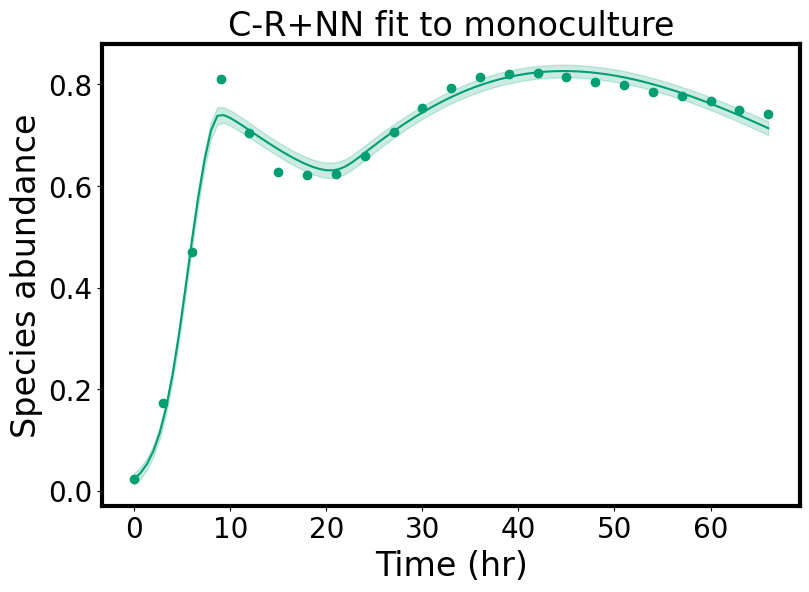

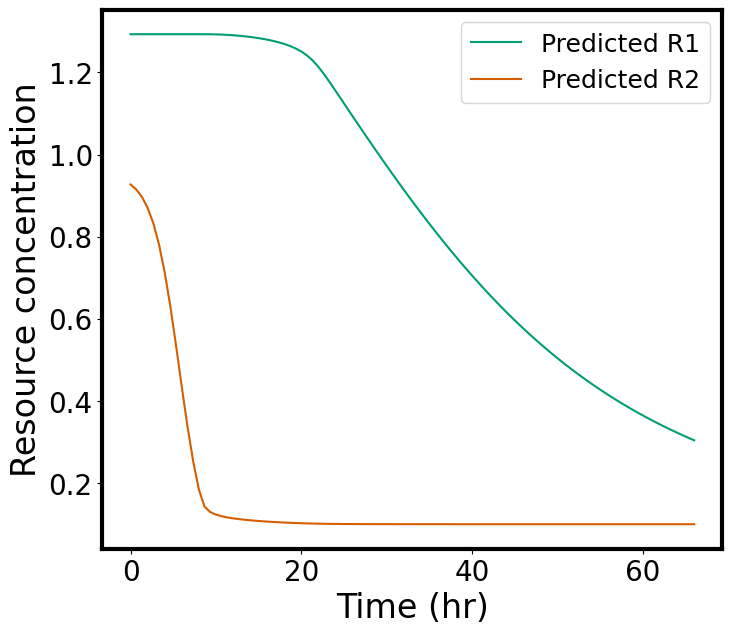

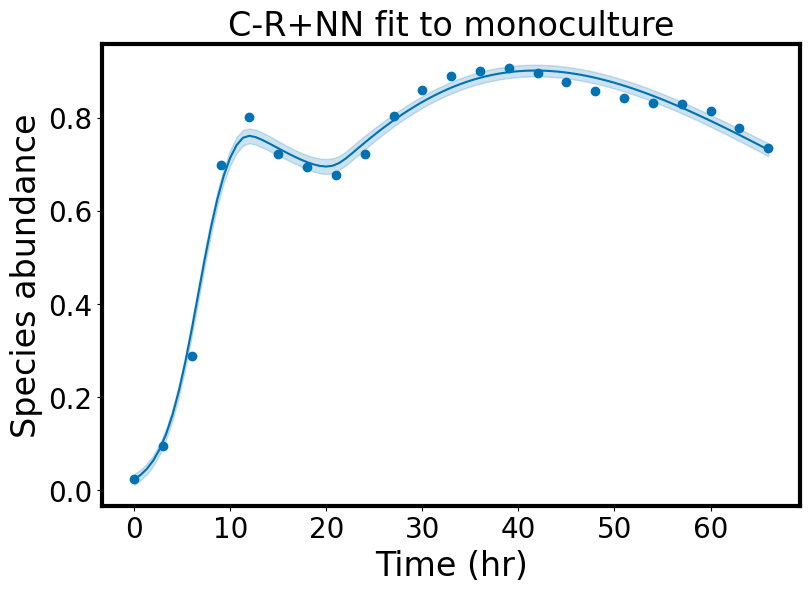

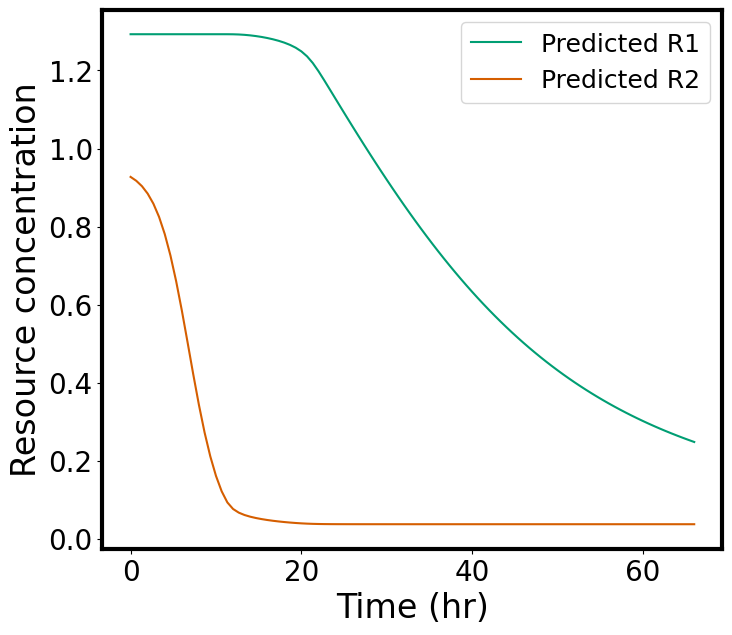

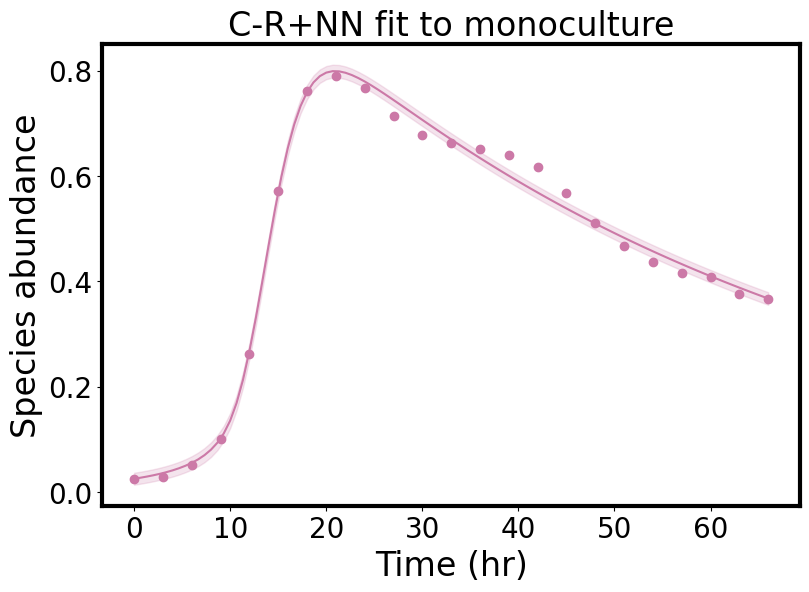

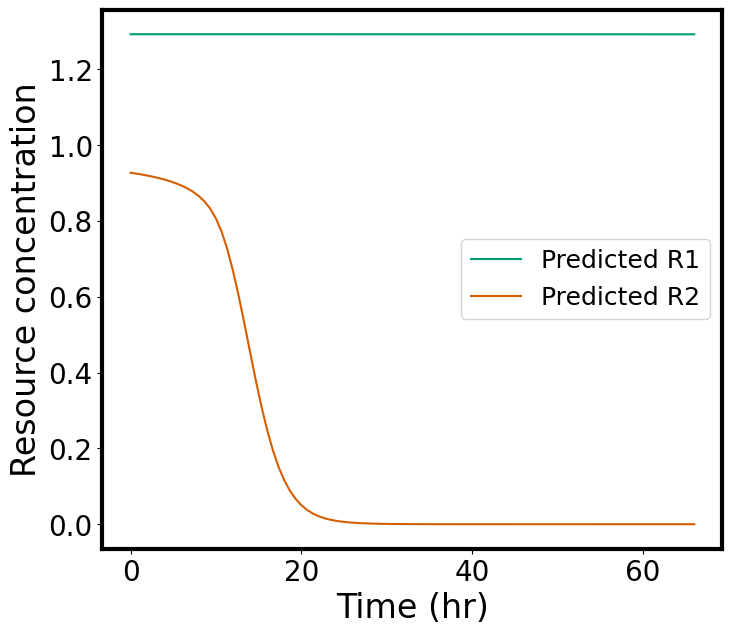

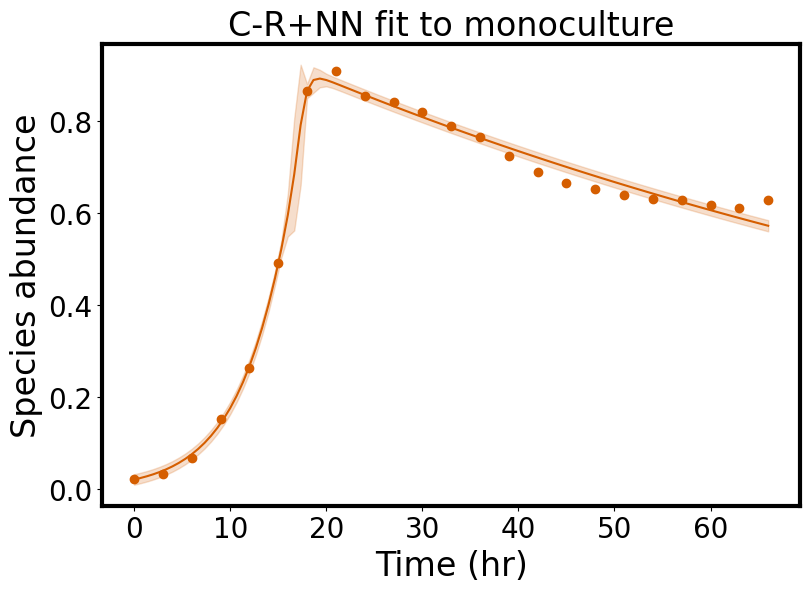

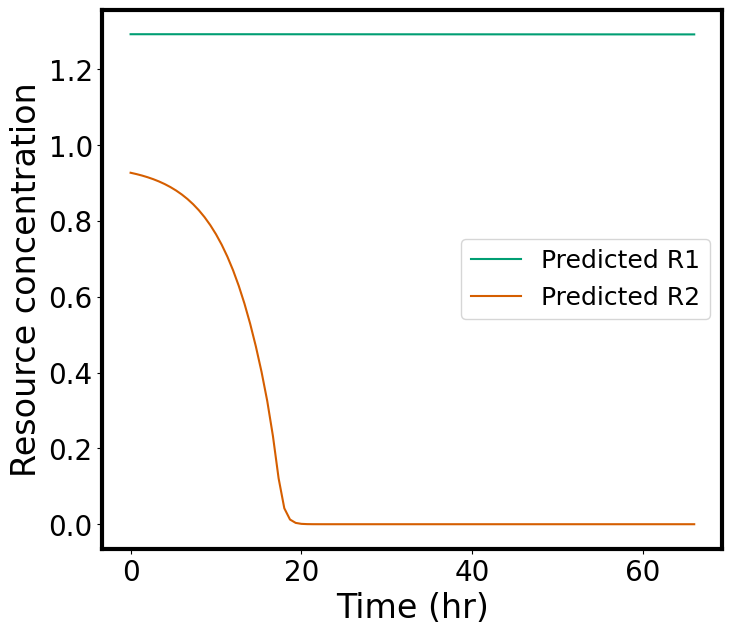

In [18]:
# model.update_precision()
plot(model, BT_data)

In [10]:
r0 = model.params[:n_r]
r0

array([ 0.25687199, -0.07542969])

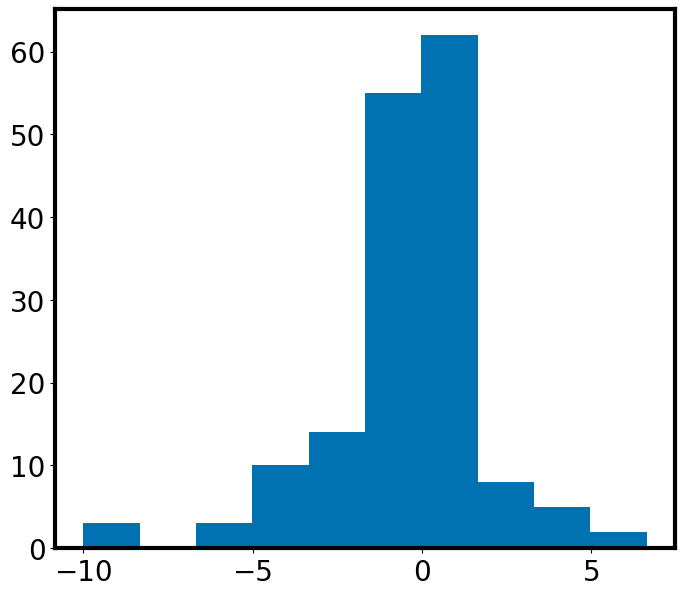

In [11]:
params = model.params[n_r:]
plt.hist(params)
plt.show()

In [12]:
# death rate
d = params[:n_s]
d

array([-3.67774387, -3.70824024, -4.6457212 , -4.00567969])

In [13]:
# efficiency of species 
f = jnp.exp(params[n_s+n_x*n_h+n_h+n_r*n_s+n_r*n_s*n_h:])
f

DeviceArray([], dtype=float32)

In [14]:
np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s])

array([[ -3.15193791,  -3.2013005 ,  -9.97886486, -10.00230881],
       [ -0.53841744,  -0.35460718,   1.00646692,  -0.62346762]])

In [15]:
# Cmax 
Cmax = np.exp(np.reshape(params[n_s+n_x*n_h+n_h:n_s+n_x*n_h+n_h+n_r*n_s], [n_r, n_s]))
Cmax.T

array([[4.27691635e-02, 5.83671214e-01],
       [4.07092272e-02, 7.01448935e-01],
       [4.63696756e-05, 2.73591770e+00],
       [4.52952307e-05, 5.36082280e-01]])

In [16]:
model.N

88.0